In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from tqdm import tqdm

# Features

### Ex 2.1

In [18]:
ROOT_DIR = "/home/sd973/rds/hpc-work/MLMI2/exp"

In [16]:
def convert_json_to_fbank(json_path):
    with open(json_path, "r") as f:
        json_data = json.load(f)

    fbank_data = {}
    for key, value in tqdm(json_data.items()):
        wav_tensor, sample_rate = torchaudio.load(value["wav"])
        fbank_tensor = torchaudio.compliance.kaldi.fbank(wav_tensor)
        # print(fbank_tensor.shape)
        # plt.plot(wav_tensor.t().numpy())

        fbank_dir = os.path.join(ROOT_DIR, "fbanks", value["spk_id"])
        fbank_name = f"{key[:-4].split('_')[1]}.fbank"
        fbank_path = os.path.join(fbank_dir, fbank_name)
        os.makedirs(fbank_dir, exist_ok=True)

        torch.save(fbank_tensor, fbank_path)

        fbank_data[key[:-4]] = {
            "fbank" : fbank_path,
            "duration" : value["duration"],
            "spk_id" : value["spk_id"],
            "phn" : value["phn"]
        }

    return fbank_data

In [19]:
fbank_train_data = convert_json_to_fbank("train.json")
with open("train_fbank.json", "w") as f:
    json.dump(fbank_train_data, f)

100%|██████████| 3696/3696 [00:25<00:00, 144.03it/s]


In [20]:
fbank_dev_data = convert_json_to_fbank("dev.json")
with open("dev_fbank.json", "w") as f:
    json.dump(fbank_dev_data, f)

100%|██████████| 400/400 [00:14<00:00, 28.12it/s]


In [21]:
fbank_test_data = convert_json_to_fbank("test.json")
with open("test_fbank.json", "w") as f:
    json.dump(fbank_test_data, f)

100%|██████████| 192/192 [00:06<00:00, 29.94it/s]


### Ex 2.2

In [43]:
with open("phone_map", "r") as f:
    vocab = set()
    for line in f.readlines():
        phn = line.strip('\n').split(':')[1].strip()
        vocab.add(phn)

with open("vocab_39.txt", "w") as f:
    for phn in list(vocab):
        f.write(f"{phn}\n")

## Use `dataloader` to get an utterance

In [7]:
from dataloader import get_dataloader
import torch
import numpy as np
from utils import concat_inputs

In [2]:
loader = get_dataloader('train_fbank.json', 1, False)
fbank, lens, trans, dur = next(iter(loader))

In [8]:
print(fbank.shape, lens.shape)
inp, lens = concat_inputs(fbank, lens, 1)
print(inp.shape)

torch.Size([378, 1, 23]) torch.Size([1])
torch.Size([378, 1, 23])


In [32]:
print('The utterance has {} seconds.'.format(dur[0]))
print('Filter bank feature has {} frames and {} dimensions.'.format(
    fbank.shape[0], fbank.shape[2]))
print('The correspoinding transcription is: {}.'.format(trans[0]))

The utterance has 3.79525 seconds.
Filter bank feature has 378 frames and 23 dimensions.
The correspoinding transcription is: sil dh ah z ae n sil s er z l sil b ih s sil t r ey f aa r w er sil d ih f y uw sil th ih ng sil dh ah m sil th r uw sil k eh r f ah l ih f er s sil t sil.


## Plot FBANK

<Figure size 640x480 with 0 Axes>

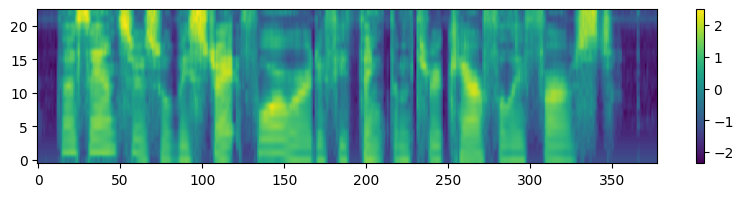

In [33]:
import matplotlib.pyplot as plt
import numpy as np

feature = np.transpose(fbank[:, 0, :].numpy())
plt.clf()
plt.figure(figsize=(10,2))
plt.imshow(feature, aspect='auto', origin='lower')
plt.colorbar()
plt.show()

# CTC model for ASR

## Obtain phoneme output units

In [3]:
# First find the unique phones in train.json, and then
# create a file named vocab.txt, each line in this 
# file is a unique phone, in total there should be 
# 40 lines

vocab = {}
phonemes = []
with open("vocab_39.txt") as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id
        phonemes.append(text)
phonemes = phonemes[1:]

In [4]:
# Count the number of times each phone appear in the training set
# and save the numbers correcponding to each phone in vocab.txt 
# into counts.txt

counts = []
with open("counts.txt") as f:
    for i in f:
        counts.append(int(i))

FileNotFoundError: [Errno 2] No such file or directory: 'counts.txt'

## Plot frequencies of graphemes

In [ ]:
plt.clf()
plt.figure(figsize=(10,2))
freq = np.array(counts) / np.sum(counts) * 100
plt.bar(phonemes, freq)
plt.show()

## Model & training configurations

In [3]:
vocab = {}
with open('vocab_39.txt') as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id

In [4]:
from collections import namedtuple
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

args = {'seed': 123,
        'train_json': 'train_fbank.json',
        'val_json': 'dev_fbank.json',
        'test_json': 'test_fbank.json',
        'batch_size': 4,
        'num_layers': 2,
        'fbank_dims': 23,
        'model_dims': 512,
        'concat': 1,
        'lr': 0.5,
        'vocab': vocab,
        'report_interval': 50,
        'num_epochs': 20,
        'device': device,
        'dropout_prob': 0.4
       }

args = namedtuple('x', args)(**args)

In [5]:
import models
model = models.BiLSTM(
    args.num_layers, args.fbank_dims * args.concat, args.model_dims, len(args.vocab), args.dropout_prob)
num_params = sum(p.numel() for p in model.parameters())
print('Total number of model parameters is {}'.format(num_params))

Total number of model parameters is 8540200


## Training

In [ ]:
from datetime import datetime
from trainer import train
start = datetime.now()
model.to(args.device)
model_path = train(model, args)
end = datetime.now()
duration = (end - start).total_seconds()
print('Training finished in {} minutes.'.format(divmod(duration, 60)[0]))
print('Model saved to {}'.format(model_path))

## Decoding

In [6]:
### You can uncomment the following line and change model path to the model you want to decode
model_path="checkpoints/20230118_113952/model_12"

In [7]:
import torch
print('Loading model from {}'.format(model_path))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Loading model from checkpoints/20230118_113952/model_12


BiLSTM(
  (lstm): LSTM(23, 512, num_layers=2, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (proj): Linear(in_features=1024, out_features=40, bias=True)
)

## 3.2.1

In [10]:
from dataloader import get_dataloader
from utils import concat_inputs

def get_prob(model, args, json_file, idx=0):
    test_loader = get_dataloader(json_file, 1, False)
    for i, data in enumerate(test_loader):
        if i < idx: continue
        inputs, in_lens, trans, _ = data
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
            return outputs

In [35]:
probs = get_prob(model, args, args.test_json, idx=3)
probs = probs.squeeze()

# "MDAB0_SX49": {
#         "fbank": "/home/sd973/rds/hpc-work/MLMI2/exp/fbanks/MDAB0/SX49.fbank",
#         "duration": 2.201625,
#         "spk_id": "MDAB0",
#         "phn": "sil ae sil t sil w aa l ay sil t ah m ah sil t sil w eh l th sil d ey w l hh ae v sh ah sil b l iy sil"
#     },

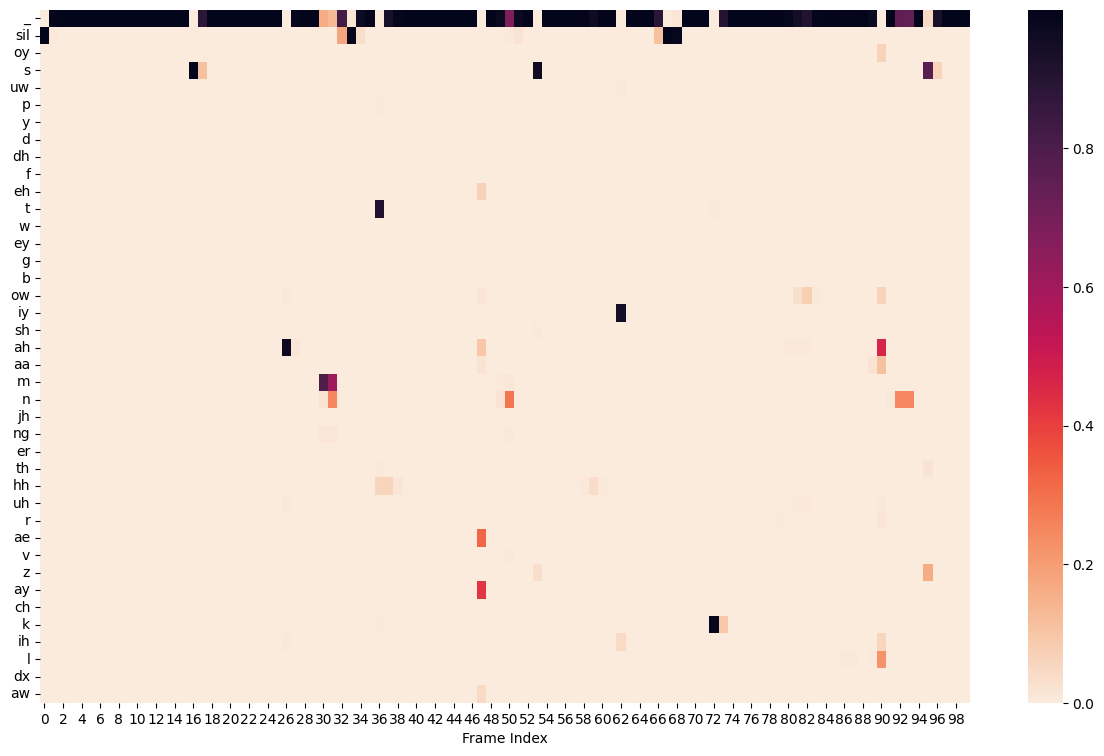

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,9))
ax = sns.heatmap(probs.T[:, :100], 
            cmap=sns.cm.rocket_r,
            yticklabels=list(vocab.keys()))
plt.xlabel("Frame Index")
plt.savefig("viz.pdf")
# plt.show()

## 3.2.2

In [36]:
from decoder import decode
results = decode(model, args, args.test_json)
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

100%|██████████| 192/192 [01:03<00:00,  3.01it/s]

SUB: 13.92%, DEL: 6.94%, INS: 2.50%, COR: 79.15%, PER: 23.36%


Default rates: SUB: 13.92%, DEL: 6.94%, INS: 2.50%, COR: 79.15%, PER: 23.36%

In [37]:
results = decode(model, args, args.test_json, blank_reduction=0.3)
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

100%|██████████| 192/192 [00:59<00:00,  3.21it/s]

SUB: 14.29%, DEL: 5.03%, INS: 3.63%, COR: 80.68%, PER: 22.95%


Blank Reduction 0.3: SUB: 14.29%, DEL: 5.03%, INS: 3.63%, COR: 80.68%, PER: 22.95%

In [38]:
results = decode(model, args, args.test_json, blank_reduction=0.5)
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

100%|██████████| 192/192 [01:02<00:00,  3.08it/s]

SUB: 14.50%, DEL: 4.10%, INS: 5.05%, COR: 81.40%, PER: 23.65%


Blank Reduction 0.5: SUB: 14.50%, DEL: 4.10%, INS: 5.05%, COR: 81.40%, PER: 23.65%

In [14]:
probs = get_prob(model, args, args.test_json, idx=0)

In [23]:
temp = torch.ones((3,1,2))


In [31]:
x = temp.squeeze()
x[:, 0] = x[:, 0] - 0.3
x

tensor([[0.7000, 1.0000],
        [0.7000, 1.0000],
        [0.7000, 1.0000]])